In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
sns.set_theme(style="darkgrid")

In [2]:
patients = pd.read_csv("model/data/eicu_patient_training.csv", index_col=0)["0"].to_list() \
        + pd.read_csv("model/data/eicu_patient_testing.csv", index_col=0)["0"].to_list()

In [179]:
with open("model/data/patients.txt", "w") as f:
    for patient in patients:
        f.write(str(patient) + "\n")

## Patient static info

age, gender, weight, height, ethnicity

In [337]:
patient_info = pd.read_csv("./eicu-collaborative-research-database-2.0/patient.csv.gz", compression="gzip")
patient_info = patient_info[patient_info["patientunitstayid"].isin(patients)][["patientunitstayid", "gender", "age", "ethnicity", "admissionheight", "admissionweight", "unitdischargestatus"]]
patient_info["unitdischargestatus"].fillna("Alive")
patient_info.age = patient_info.age.replace("> 89", "89").astype(int)
# patient_info.to_csv("model/data/eicu_patients_basic_info.csv", index=False)

In [336]:
patient_info.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,...,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665


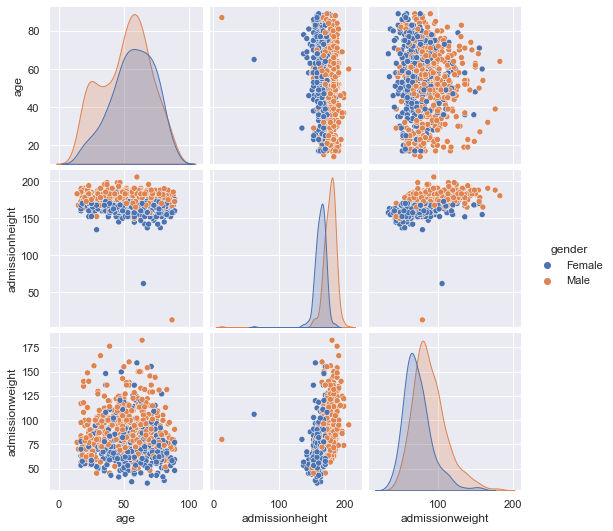

In [164]:
sns.pairplot(patient_info[["gender", "age", "ethnicity", "admissionheight", "admissionweight"]], hue="gender")

In [338]:
apache = pd.read_csv("./eicu-collaborative-research-database-2.0/apachePredVar.csv.gz", compression="gzip")

In [340]:
apache["GCS"] = apache["verbal"] + apache["motor"] + apache["eyes"]

In [345]:
patient_info1 = patient_info.merge(apache[["patientunitstayid", "GCS"]], how="left", on="patientunitstayid")

In [347]:
patient_info1.to_csv("model/data/eicu_patients_basic_info_updated.csv", index=False)

## Diagnoses features

TBI:
ICD10CM: S02*, S04*, S06*, S07*, S09*, T02, T04, T06
ICD9CM: 800*, 801*, 802*, 803*, 804*, 850.1 – 850.5, 850.9, 851*, 852*, 853*, 854*, 959.01

Severe TBI:
G93.5/348.4 Brain herniation, G93.6 Brain edema

Intracerebral Hemorrhage:
I61, 431, 432
I60, 430
430, 331.3, G91.0, I60.9
I62.01, I62.02, 4321
I62.1, 4320

Acute Ischemic Stroke:
I63, 433, 434.x1, I65

Cerebral Venous Thrombosis:
437.6, I67.6

Hepatic encephalopathy and other non neurological encephalopathy:
572.2, K72.01, K72.11,K72.91
348.30, G93.40

Chronic Neurosurgical Conditions (code all as 1 variable, there should be very few):
331.3, 331.4, 331.5, G91
348.2, G93.2
I62.03

In [ ]:
diag = pd.read_csv("./eicu-collaborative-research-database-2.0/diagnosis.csv.gz", compression="gzip")

In [ ]:
diagnoses = [
    "TBI", "Severe-TBI", "IH", "AIS", "CVT", "HE", "CNC"
]


diagnosis_types_regex = [
    r"^(S0[24679]|T0[246]|80[0-4]|850.[1-59]|85[1-4]|959.01$)", 
    r"^G93.[56]",
    r".*(G91.0|I6[01]|I62.(0[12]|1)|43[012]|331.3)",
    r".*(I63|433|434.[0-9]1|I65)",
    r".*(437.6|I67.6)",
    r".*(572.2|K72.01|K72.11|K72.91|348.30|G93.40)",
    r".*(331.[345]|G91|348.2|G93.2|I62.03)"
]

diagnosis_types = []

for regex in diagnosis_types_regex:
    diagnosis_types.append(list(diag.loc[diag['icd9code'].str.match(regex) == True]["patientunitstayid"].unique()))
    

In [175]:
patient_diags = []
for patient in patients:
    diags = [patient] + [0 for _ in range(len(diagnosis_types))]
    for i, diag_type in enumerate(diagnosis_types):
        if patient in diag_type:
            diags[i+1] = 1
    patient_diags.append(diags)

patient_diags = pd.DataFrame(patient_diags, columns=["patientunitstayid"] +diagnoses)
patient_diags.to_csv("model/data/eicu_patient_diagnoses.csv", index=False)

## Vital Signs (from nurse charting)

In [130]:
vitals = [
    'Glasgow coma score - Eyes',
    'Glasgow coma score - GCS Total',
    'Glasgow coma score - Motor',
    'Glasgow coma score - Verbal',
    'Invasive BP - Invasive BP Diastolic',
    'Invasive BP - Invasive BP Mean',
    'Invasive BP - Invasive BP Systolic',
    'Non-Invasive BP - Non-Invasive BP Diastolic',
    'Non-Invasive BP - Non-Invasive BP Mean',
    'Non-Invasive BP - Non-Invasive BP Systolic',
    'CVP - CVP',
    'Temperature - Temperature (C)',
    'Heart Rate - Heart Rate',
    'Respiratory Rate - Respiratory Rate',
    'SpO2 - Value',
]

In [ ]:
nurseCharting = pd.read_csv("./eicu-collaborative-research-database-2.0/nurseCharting.csv.gz", compression="gzip", chunksize=50000)
nurse = pd.DataFrame()
for n in tqdm(nurseCharting):
    nurse = nurse.append(n.loc[(n['patientunitstayid'].isin(patients))])

In [181]:
cols = list(nurse.columns)

for col in cols:
    if "offset" in col:
        print(col)

nursingchartoffset
nursingchartentryoffset


In [ ]:
nurse["comb"] = nurse["nursingchartcelltypevallabel"] + " - " + nurse["nursingchartcelltypevalname"]

In [176]:
# sorted(nurse["comb"].unique())
for vital in vitals:
    print(vital, nurse[nurse["comb"]==vital].shape)

Glasgow coma score - Eyes (119482, 9)
Glasgow coma score - GCS Total (137601, 9)
Glasgow coma score - Motor (119450, 9)
Glasgow coma score - Verbal (119408, 9)
Invasive BP - Invasive BP Diastolic (132460, 9)
Invasive BP - Invasive BP Mean (117982, 9)
Invasive BP - Invasive BP Systolic (132462, 9)
Non-Invasive BP - Non-Invasive BP Diastolic (291773, 9)
Non-Invasive BP - Non-Invasive BP Mean (266981, 9)
Non-Invasive BP - Non-Invasive BP Systolic (291776, 9)
CVP - CVP (29439, 9)
Temperature - Temperature (C) (176316, 9)
Heart Rate - Heart Rate (391035, 9)
Respiratory Rate - Respiratory Rate (366527, 9)
SpO2 - Value (436, 9)


In [189]:
patient_vitals[["a","b"]] = pd.DataFrame([patient_vitals["nursingchartoffset"], patient_vitals["nursingchartoffset"] -1])

ValueError: Columns must be same length as key

In [194]:
patient_vitals.iloc[1,:]

patientunitstayid                                        2731139
nursingchartoffset                                          -262
nursingchartvalue                                            134
comb                  Non-Invasive BP - Non-Invasive BP Systolic
a                                                           -262
b                     Non-Invasive BP - Non-Invasive BP Systolic
Name: 110735799, dtype: object

In [131]:
sorted_nurse = nurse[["patientunitstayid", "nursingchartoffset", "nursingchartvalue", "comb"]].loc[(nurse['comb'].isin(vitals))].sort_values(by=['patientunitstayid', "nursingchartoffset", "comb"])

In [132]:
records = []
for patient in tqdm(patients):
    patient_vitals = sorted_nurse[sorted_nurse['patientunitstayid']==patient]
    for time in patient_vitals["nursingchartoffset"].unique():
        record = [patient, time] + [np.nan for _ in range(len(vitals))]
        pv = patient_vitals[patient_vitals["nursingchartoffset"]==time]
        for index, row in pv.iterrows():
            record[2 + vitals.index(row["comb"])] = row["nursingchartvalue"]
        records.append(record)

100%|████████████████████████████████████████████████████████████████████████████████| 889/889 [07:07<00:00,  2.08it/s]


In [168]:
vitals_records = pd.DataFrame(records, columns=["patientunitstayid", "offset"] + vitals)

In [171]:
vitals_records.to_csv("model/data/eicu_vitals_records.csv", index=False)

## Drugs

In [348]:
sal = [
    ' 3% NACL (ml/hr)',
 '3 % NaCl (ml/hr)',
 '3 % SALINE (ml/hr)',
 '3 % saline (ml/hr)',
 '3 %NaCl (ml/hr)',
 '3 NACL (ml/hr)',
 '3 nacl (ml/hr)',
 '3%  SALINE (ml/hr)',
 '3% HYPERTONIC SALINE (ml/hr)',
 '3% Hypertonic NaCl (ml/hr)',
 '3% Hypertonic Saline',
 '3% Hypertonic Saline (ml/hr)',
 '3% NACL (ml/hr)',
 '3% NORMAL SALINE (ml/hr)',
 '3% NaCL  (ml/hr)',
 '3% NaCL (ml/hr)',
 '3% NaCl (ml/hr)',
 '3% Nacl (ml/hr)',
 '3% Normal Saline (ml/hr)',
 '3% SALINE (ml/hr)',
 '3% Saline (ml/hr)',
 '3% hypertonic saline  (ml/hr)',
 '3% hypertonic saline (ml/hr)',
 '3% nacl (ml/hr)',
 '3% normal saline (ml/hr)',
 '3% saline',
 '3% saline (ml/hr)',
 '3%NACL (ml/hr)',
 '3%NaCL (ml/hr)',
 '3%NaCl (ml/hr)',
 '3%Nacl (ml/hr)',
 '3%hypertonic saline (ml/hr)',
'Hypertonic 3% Saline (ml/hr)',
 'Hypertonic 3% saline (ml/hr)',
 'Hypertonic Saline (ml/hr)',
 'Hypertonic Saline 3% (ml/hr)',
 'Hypertonic saline (ml/hr)',
'NaCl 3% (ml/hr)',
 'NaCl 3% Hypertonic (ml/hr)',
'hypertonic saline (ml/hr)',
    "NaCl 3% (Hypertonic Saline)",
]

sal_d = [ '23.4% NaCl (ml/hr)',
 '23.4% nacl (ml/hr)',]

man = [
    'Mannitol (ml/hr)',
 'Mannitol 20%',
 'Mannitol 20% (ml/hr)',
 'Mannitol IVF Infused (ml/hr)',
 'mannitol (ml/hr)',
]

drug_categories = [
    [
        "Propofol",
        "Lorazepam",
        "Midazolam",
        "Dexmedetomidine",
        "Diazepam",
        "Haloperidol",
        "Etomidate",
        #Barbituate (in eICU under treatment: neurologic|therapy for controlling cerebral perfusion pressure|sedative agent|barbiturate),
        "Pentobarbital",
    ], 
    [
        "Cisatracurium",
        "Vecuronium",
        "Rocuronium",
        "Atracurium",
    ],
    [
        "Nicardipine",
        "Nicardipine 40mg/200",
        "Labetalol",
        "Hydralazine",
        "Nimodipine",
        "Metoprolol",
        "Esmolol",
        "Milrinone",
        "Dilitazem",
        "Clevidipine",
        "Meperidine",
        "Verapamil",
    ],
    [
        "Norepinephrine",
        "Phenylephrine",
        "Phenylephrine (50/250)",
        "Phenylephrine (200/250)",
        "Dopamine",
        "Dobutamine",
        "Epinephrine",
        "Vasopressin",
    ],
    [
        "Fentanyl",
        "Fentanyl concentrate",
        "Hydromorphone (Dilaudid)",
        "Morphine Sulfate",
        "Meperidine (Demerol)",
        "Acetaminophen",
    ],
    [
        "Heparin",
        "Heparin Sodium",
        "Enoxaparin (Lovenox)",
        "Coumadin (Warfarin)",
    ],
    [
        "Keppra (Levitaceram)",
        "Gabapentin",
        "Diazepam",
        "Fosphenytoin",
    ],
    [
        "OR Crystalloid Intake",
        "D5 1/2NS",
        "D5NS",
        "OR Colloid Intake",
        "D5LR",
        "Albumin 5%",
        "Dextrose 50%",
        "Albumin 25%",
        "Dextrose 10%"
    ]
]

drug_category_names = [
    "Sedatives", "Paralytics", "Antihypertensives", "Vasopressors", "Opoids", "Anticoagulants", "Anti-epileptics", "Fluid Resuscitation"
]

In [172]:
drugs = pd.read_csv("./eicu-collaborative-research-database-2.0/infusionDrug.csv.gz", compression="gzip")

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3173: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [360]:
def label_drug(row):
#     if str(row["drugname"]) in man:
#         return "mannitol"
#     elif str(row["drugname"]) in sal:
#         return "hypertonic saline"
#     else:
    for i, category in enumerate(drug_categories):
        if str(row["drugname"]) in category:
            return drug_category_names[i]
    return "others"

patient_drugs1 = drugs[drugs["patientunitstayid"].isin(patients)].copy()
patient_drugs1["drug_all"] = patient_drugs1.apply(label_drug, axis=1)

In [361]:
patient_drugs1.value_counts(["drug_all"]).sort_index()

drug_all         
Anticoagulants            3
Antihypertensives        98
Opoids                   64
Sedatives               127
Vasopressors             86
others               128966
dtype: int64

In [362]:
patient_drugs1 = patient_drugs1[patient_drugs1["drug_all"].isin(drug_category_names)]

In [365]:
patient_drugs1.shape

(378, 10)

In [364]:
patient_drugs1.isna().sum()

infusiondrugid         0
patientunitstayid      0
infusionoffset         0
drugname               0
drugrate             378
infusionrate         378
drugamount           378
volumeoffluid        378
patientweight        378
drug_all               0
dtype: int64

In [366]:
patient_drugs1_onehot = pd.get_dummies(patient_drugs1["drug_all"]).astype(int)

In [368]:
drugs1_final = pd.concat([patient_drugs1[["patientunitstayid", "infusionoffset"]], patient_drugs1_onehot], axis=1)

In [369]:
drugs1_final["offset"] = drugs1_final.apply(interpolate_infusion_offset, axis=1)

In [370]:
drugs1_final

,patientunitstayid,infusionoffset,Anticoagulants,Antihypertensives,Opoids,Sedatives,Vasopressors,offset
345761,502503,18192,0,1,0,0,0,18195
345767,502503,18132,0,0,0,0,1,18135
345771,502503,18132,0,1,0,0,0,18135
345845,502503,18072,0,1,0,0,0,18075
345897,502503,18192,0,0,0,0,1,18195
...,...,...,...,...,...,...,...,...
4519942,3125185,3499,0,0,0,0,1,3500
4695457,3208770,29172,0,0,0,1,0,-10000
4732572,3229717,2928,0,0,1,0,0,3130
4735535,3232358,7020,0,0,0,1,0,6026


In [373]:
c = ["Anticoagulants","Antihypertensives","Opoids","Sedatives","Vasopressors"]

In [374]:
vitals3 = vitals2.merge(drugs1_final, how="left", left_on=["patientunitstayid", "observationoffset"], right_on=["patientunitstayid", "offset"])
vitals3[c] = vitals3[c].fillna(0)

In [375]:
vitals3_cumsum_list = []
for patient in list(vitals3["patientunitstayid"].unique()):
    patient_vt = vitals3[vitals3["patientunitstayid"]==patient].copy()
    for col in c:
        patient_vt["Culmulative " + col] = patient_vt[col].cumsum()
    vitals3_cumsum_list.append(patient_vt)

In [376]:
vitals3_cumsum = pd.concat(vitals3_cumsum_list, axis=0)

In [383]:
vitals3_cumsum.drop(["offset", "infusionoffset"], axis=1).to_csv("model/data/eicu_vitals_final.csv", index=False)

In [358]:
patient_drugs1["drugrate"].astype("float32")

345761    NaN
345767    NaN
345771    NaN
345845    NaN
345897    NaN
           ..
4519942   NaN
4695457   NaN
4732572   NaN
4735535   NaN
4758829   NaN
Name: drugrate, Length: 378, dtype: float32

In [279]:
hm = patient_drugs[(patient_drugs["drug"].isin(["hypertonic saline", "mannitol"])) & (patient_drugs["drugrate"] > 0)]

In [291]:
hm.head()

,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight,drug
13389,1965137.0,306989.0,1625.0,NaCl 3% (ml/hr),30.0,30.0,NaN,NaN,NaN,hypertonic saline
13390,1953244.0,306989.0,1865.0,NaCl 3% (ml/hr),30.0,30.0,NaN,NaN,NaN,hypertonic saline
13391,1950727.0,306989.0,2165.0,NaCl 3% (ml/hr),30.0,30.0,NaN,NaN,NaN,hypertonic saline
13392,1958210.0,306989.0,425.0,NaCl 3% (ml/hr),30.0,30.0,NaN,NaN,NaN,hypertonic saline
93123,6113268.0,443007.0,17678.0,3% SALINE (ml/hr),40.0,40.0,NaN,NaN,NaN,hypertonic saline


In [286]:
hm_onehot = pd.get_dummies(hm["drug"]).astype(int) #* hm[["drugrate", "drugrate"]].astype(float)

In [289]:
# hm_onehot["hypertonic saline"] = hm_onehot["hypertonic saline"] * hm["drugrate"]
# hm_onehot["mannitol"] = hm_onehot["mannitol"] * hm["drugrate"]

In [295]:
hm_final = pd.concat([hm[["patientunitstayid", "infusionoffset"]], hm_onehot], axis=1)

In [318]:
def interpolate_infusion_offset(row):
    offsets = vitals[vitals["patientunitstayid"]==row["patientunitstayid"]]["observationoffset"].astype(int).to_list()
    offset = -10000
    min_diff = 1000
    for po in offsets:
        if abs(po - row["infusionoffset"]) < min_diff:
            min_diff = abs(po - offset)
            offset = po
    return offset

In [319]:
hm_final["offset"] = hm_final.apply(interpolate_infusion_offset, axis=1)

In [320]:
vitals2 = vitals1.merge(hm_final, how="left", left_on=["patientunitstayid", "observationoffset"], right_on=["patientunitstayid", "offset"])
vitals2[["hypertonic saline", "mannitol"]] = vitals2[["hypertonic saline", "mannitol"]].fillna(0)

In [324]:
vitals2 = vitals2.drop(["offset", "infusionoffset", "Unnamed: 0"], axis=1)#.to_csv("model/data/eicu_vitals_treatments_hts_m.csv", index=False)

## Culmulative procedures

In [325]:
vitals2.head()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,systemicsystolic,systemicdiastolic,systemicmean,...,Invasive BP - Invasive BP Systolic,Non-Invasive BP - Non-Invasive BP Diastolic,Non-Invasive BP - Non-Invasive BP Systolic,Intracranial operations,Lumbar Puncture,Mechanical Ventilation,Neurovascular Procedures,Shunting,hypertonic saline,mannitol
0,39121950,143881,450,26.2,100.0,68.0,29.0,148.0,44.0,70.0,...,164.0,61.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39121791,143881,455,26.2,100.0,66.0,28.0,146.0,44.0,70.0,...,164.0,61.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39121631,143881,460,26.2,100.0,68.0,27.0,150.0,46.0,72.0,...,156.0,54.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39121469,143881,465,26.2,99.0,64.0,18.0,146.0,44.0,70.0,...,156.0,54.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39121308,143881,470,26.2,100.0,68.0,19.0,148.0,46.0,70.0,...,156.0,54.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [330]:
vitals2_cumsum_list = []
for patient in list(vitals2["patientunitstayid"].unique()):
    patient_vt = vitals2[vitals2["patientunitstayid"]==patient].copy()
    for col in ["Intracranial operations","Lumbar Puncture","Mechanical Ventilation","Neurovascular Procedures","Shunting","hypertonic saline","mannitol"]:
        patient_vt["Culmulative " + col] = patient_vt[col].cumsum()
    vitals2_cumsum_list.append(patient_vt)


In [331]:
vitals2_cumsum = pd.concat(vitals2_cumsum_list, axis=0)

In [334]:
vitals2_cumsum.to_csv("model/data/eicu_vitals_treatments_drug_cumsum.csv", index=False)

## Labs

In [3]:
lab = pd.read_csv("./eicu-collaborative-research-database-2.0/lab.csv.gz", compression="gzip")

In [4]:
# sorted(list(lab["labname"].unique()))

In [5]:
sodium = lab[(lab["patientunitstayid"].isin(patients)) & (lab["labname"].isin(["sodium"]))].rename(columns={"labresult": "sodium"})
glucose = lab[(lab["patientunitstayid"].isin(patients)) & (lab["labname"].isin(["glucose"]))].rename(columns={"labresult": "glucose"})

In [6]:
sod_glu = sodium[["patientunitstayid", "labresultoffset", "sodium"]].merge(glucose[["patientunitstayid", "labresultoffset", "glucose"]], how="outer", on=["patientunitstayid", "labresultoffset"])

In [7]:
sod_glu = sod_glu.sort_values(["patientunitstayid", "labresultoffset"])

In [8]:
sglist = []
for patient in patients:
    sglist.append(sod_glu[sod_glu["patientunitstayid"]==patient].fillna(method="ffill"))
    

In [9]:
sg = pd.concat(sglist)

In [11]:
sg.patientunitstayid.nunique()

887

In [10]:
lab1.sort_values(["patientunitstayid", "labresultoffset", "labname"])

,labid,patientunitstayid,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
61324,47294846,143881,-90,1,glucose,105.0,105,mg/dL,mg/dL,-60
61260,47294840,143881,-90,1,sodium,141.0,141,mmol/L,mmol/L,-60
61244,43248444,143881,497,1,glucose,148.0,148,mg/dL,mg/dL,519
61232,43248441,143881,497,1,sodium,138.0,138,mmol/L,mmol/L,519
61199,42805220,143881,718,1,sodium,141.0,141,mmol/L,mmol/L,745
...,...,...,...,...,...,...,...,...,...,...
39075347,823725690,3351831,13991,1,sodium,134.0,134,mmol/L,mmol/L,14068
39075434,823644234,3351831,17310,1,glucose,110.0,110,mg/dL,mg/dL,17343
39075478,824391783,3351831,17310,1,sodium,131.0,131,mmol/L,mmol/L,17343
39075479,822048101,3351831,18669,1,glucose,98.0,98,mg/dL,mg/dL,18714


In [12]:
vitals = pd.read_csv("model/data/eicu_vitals_final.csv")

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3173: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
vpatients = list(vitals.patientunitstayid.unique())


## Procedures and Treatment

In [207]:
treatments = pd.read_csv("./eicu-collaborative-research-database-2.0/treatment.csv.gz", compression="gzip")

In [224]:
treatment_types = [
    [
        "neurologic|therapy for controlling cerebral perfusion pressure|intracranial/cerebral perfusion pressure monitoring|CSF drainage via ventriculostomy",
        "neurologic|procedures / diagnostics|intracranial/cerebral perfusion pressure monitoring|ventriculostomy",
        "neurologic|procedures / diagnostics|neurosurgery|ventricular shunt procedure",
        "neurologic|procedures / diagnostics|neurosurgery|ventricular shunt procedure|ventricular-peritoneal",
        "neurologic|procedures / diagnostics|neurosurgery|ventricular shunt procedure|lumbar-peritoneal",
        "neurologic|procedures / diagnostics|neurosurgery|ventricular shunt procedure|ventricular-atrial",

    ], 
    [
        "neurologic|procedures / diagnostics|neurosurgery|therapeutic craniotomy|for hematoma",
        "neurologic|ICH/ cerebral infarct|surgery|craniotomy for drainage of intracranial hematoma",
        "neurologic|procedures / diagnostics|neurosurgery|drainage of hematoma-craniotomy",
        "neurologic|procedures / diagnostics|neurosurgery|diagnostic craniotomy",
        "neurologic|procedures / diagnostics|neurosurgery|hemicraniectomy",
        "neurologic|ICH/ cerebral infarct|surgery|hemicraniectomy",

    ],
    [
        "neurologic|procedures / diagnostics|lumbar puncture"
    ], 
    [
        "neurologic|procedures / diagnostics|angiogram|with coiling",
        "neurologic|procedures / diagnostics|angiogram|with embolization",
        "neurologic|ICH/ cerebral infarct|angiogram|with coiling",
        "neurologic|procedures / diagnostics|angiogram|with infusion of vasodilator",
        "neurologic|ICH/ cerebral infarct|angiogram|with embolization",
        "neurologic|ICH/ cerebral infarct|angiogram|with infusion of vasodilator",
        "neurologic|ICH/ cerebral infarct|angiogram|with cerebral angioplasty",
        "neurologic|procedures / diagnostics|angiogram|with stenting",

    ], 
    [
        "pulmonary|ventilation and oxygenation|mechanical ventilation"
    ]
]

types = [
    "Shunting", "Intracranial operations", "Lumbar Puncture", "Neurovascular Procedures", "Mechanical Ventilation"
]


def label_treatment(row):
    for i, group in enumerate(treatment_types):
        if str(row["treatmentstring"]) in group:
            return types[i]
    return -1
    

In [225]:
treatments["treatmenttype"] = treatments.apply(label_treatment, axis=1)

In [226]:
treatments["treatmenttype"].value_counts()

-1                          3558345
Mechanical Ventilation       117481
Shunting                       5170
Neurovascular Procedures       3000
Intracranial operations        2780
Lumbar Puncture                1969
Name: treatmenttype, dtype: int64

In [227]:
treatments_out = treatments.loc[(treatments["patientunitstayid"].isin(patients)) & (treatments["treatmenttype"]!=-1)]

In [228]:
len(treatments_out["patientunitstayid"].unique())

709

In [229]:
treatments_out = treatments_out.sort_values(by=['patientunitstayid', "treatmentoffset", "treatmenttype"])

In [230]:
# treatments_csv = []
# for patient in patients:
#     diags = [patient] + [0 for _ in range(len(types))]
#     for i, diag_type in enumerate(types):
#         if patient in diag_type:
#             diags[i+1] = 1
#     patient_diags.append(diags)

# patient_diags = pd.DataFrame(patient_diags, columns=["patientunitstayid"] +diagnoses)
# patient_diags.to_csv("model/data/eicu_patient_diagnoses.csv", index=False)

In [234]:
onehot = pd.get_dummies(treatments_out["treatmenttype"])
onehot_treatments = treatments_out[["patientunitstayid", "treatmentoffset"]].join(onehot)

In [236]:
onehot_treatments.to_csv("eicu_treatment_types.csv", index=False)

In [238]:
vitals = pd.read_csv("model/data/eicu_all_vitals.csv")

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3173: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [311]:
def interpolate_offset(row):
    offsets = vitals[vitals["patientunitstayid"]==row["patientunitstayid"]]["observationoffset"].astype(int).to_list()
    offset = -10000
    min_diff = 120
    for po in offsets:
        if abs(po - row["treatmentoffset"]) < min_diff:
            min_diff = abs(po - offset)
            offset = po
    return offset

In [312]:
# vitals_patients = list(vitals["patientunitstayid"].unique())
onehot_treatments["offset"] = onehot_treatments.apply(interpolate_offset, axis=1)

In [313]:
vitals1 = vitals.merge(onehot_treatments, how="left", left_on=["patientunitstayid", "observationoffset"], right_on=["patientunitstayid", "offset"])

In [314]:
vitals1[types] = vitals1[types].fillna(0)

In [317]:
vitals1.drop(["treatmentoffset", "offset"], axis=1, inplace=True)

In [258]:
vitals1.drop("treatmentoffset", axis=1).to_csv("model/data/eicu_vitals_treatments.csv", index=False)

In [316]:
vitals1[types].sum()

Shunting                    3152.0
Intracranial operations      480.0
Lumbar Puncture                5.0
Neurovascular Procedures    1010.0
Mechanical Ventilation      2897.0
dtype: float64